In [1]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import keras
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import load_img, img_to_array
from sklearn.model_selection import train_test_split
from keras.utils import load_img, img_to_array
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Activation, LeakyReLU, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
import glob
from collections import defaultdict

2024-07-11 15:51:09.564141: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-11 15:51:09.903109: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import tensorflow as tf

# Check if TensorFlow can access a GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Check CUDA version used by TensorFlow
cuda_version = tf.sysconfig.get_build_info().get('cuda_version')
cudnn_version = tf.sysconfig.get_build_info().get('cudnn_version')

print("CUDA version: ", cuda_version)
print("cuDNN version: ", cudnn_version)


Num GPUs Available:  1
CUDA version:  11.8
cuDNN version:  8


2024-07-11 15:51:14.449826: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-11 15:51:14.484223: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-11 15:51:14.484314: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    #array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), IMAGE_SIZE, IMAGE_SIZE, 3))
    return array

def one_depreprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype("float32") * 255.0
    array = np.reshape(array, (IMAGE_SIZE, IMAGE_SIZE, 3))
    return array

def depreprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    #array = array.astype("float32") * 255.0
    array = np.reshape(array, (len(array), IMAGE_SIZE, IMAGE_SIZE, 3))
    return array

In [4]:
IMAGE_SIZE = 256

In [5]:
train_data_path = '/home/takanolab/proglams_python/data' # ここを変更。Colaboratoryにアップロードしたzipファイルを解凍後の、データセットのフォルダ名を入力
image_size = IMAGE_SIZE # ここを変更。必要に応じて変更してください。「28」を指定した場合、縦28横28ピクセルの画像に変換します。
color_setting = 3  #ここを変更。データセット画像のカラー：「1」はモノクロ・グレースケール。「3」はカラー。
folder = ['hatake','kawa','mori','tatemono'] # ここを変更。データセット画像のフォルダ名（クラス名）を半角英数で入力
class_number = len(folder)
print('Num of classes : ', str(class_number))

Num of classes :  4


In [6]:
X_image = []  
Y_label = []

label_count = np.zeros(class_number)
for index, name in enumerate(folder):
  read_data = train_data_path + '/' + name
  files = glob.glob(read_data + '/*.png') #ここを変更。png形式のファイルを利用する場合のサンプルです。
  print('loaded dataset : ', read_data)
  num=0
  for i, file in enumerate(files):
    if color_setting == 1:
      img = load_img(file, color_mode = 'grayscale' ,target_size=(image_size, image_size))  
    elif color_setting == 3:
      img = load_img(file, color_mode = 'rgb' ,target_size=(image_size, image_size))
    array = img_to_array(img)
    X_image.append(array)
    num +=1
    Y_label.append(index)
  print('index: ',index,' num:',num)
  label_count[index] = num

X_image = np.array(X_image)
Y_label = np.array(Y_label)

X_image = X_image.astype('float32') / 255
print(len(X_image))

loaded dataset :  /home/takanolab/proglams_python/data/hatake
index:  0  num: 144
loaded dataset :  /home/takanolab/proglams_python/data/kawa
index:  1  num: 144
loaded dataset :  /home/takanolab/proglams_python/data/mori
index:  2  num: 144
loaded dataset :  /home/takanolab/proglams_python/data/tatemono
index:  3  num: 144
576


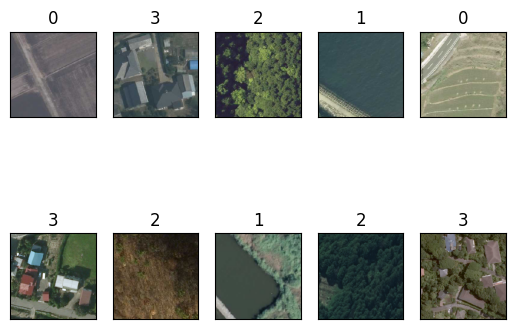

In [7]:
train_images, valid_images ,train_labels ,valid_labels = train_test_split(X_image,Y_label,test_size=0.20,shuffle = True)
x_train = train_images
y_train = train_labels
x_test = valid_images
y_test = valid_labels

n=5
for i in range(10):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[[i]].reshape(image_size,image_size,3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(str(y_train[i]))
plt.show()

In [8]:
LEARNING_RATE = 0.0003
BATCH_SIZE = 64
Z_DIM = 100
EPOCHS = 800

encoder_input = Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3), name='encoder_input')
x = encoder_input
x = Conv2D(filters=3, kernel_size=3, strides=1, padding='same', name='encoder_conv_0')(x)
x = LeakyReLU()(x)
x = Conv2D(filters=16, kernel_size=3, strides=2, padding='same', name='encoder_conv_1')(x)
x = LeakyReLU()(x)
x = Conv2D(filters=32, kernel_size=3, strides=2, padding='same', name='encoder_conv_2')(x)
x = LeakyReLU()(x)
x = Conv2D(filters=64, kernel_size=3, strides=2, padding='same', name='encoder_conv_3')(x)
x = LeakyReLU()(x)
x = Conv2D(filters=128, kernel_size=3, strides=2, padding='same', name='encoder_conv_4')(x)
x = LeakyReLU()(x)
#encoder_output2=Dense(Z_DIM, name='encoder_output')(x)
shape_before_flattening = K.int_shape(x)[1:]
x = Flatten()(x)
encoder_output = Dense(Z_DIM, name='encoder_output')(x)
encoder = Model(encoder_input, encoder_output)

# デコーダ
decoder_input = Input(shape=(Z_DIM,), name='decoder_input')
x = Dense(np.prod(shape_before_flattening))(decoder_input)
x = Reshape(shape_before_flattening)(x)
x = Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same', name='decoder_conv_4')(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', name='decoder_conv_3')(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', name='decoder_conv_2')(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same', name='decoder_conv_1')(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(filters=3, kernel_size=3, strides=1, padding='same', name='decoder_conv_0')(x)
x = Activation('sigmoid')(x)
decoder_output = x
decoder = Model(decoder_input, decoder_output)

2024-07-11 15:51:22.713815: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-11 15:51:22.714007: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-11 15:51:22.714107: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [9]:
# エンコーダ/デコーダ連結
model_input = encoder_input
model_output = decoder(encoder_output)
model = Model(model_input, model_output)

# 学習用設定設定（最適化関数、損失関数）
optimizer = Adam(learning_rate=LEARNING_RATE)

#https://keras.io/api/losses/regression_losses/#meansquarederror-class
def r_loss(y_true, y_pred):
  return K.mean(K.square(K.log(y_true + 1) - K.log(y_pred + 1)), axis=-1)
#def r_loss(y_true, y_pred):
#  return K.mean(K.square(y_true - y_pred), axis=[1,2,3])

model.compile(optimizer=optimizer, loss=r_loss, metrics=['accuracy'])

In [10]:
history=model.fit(
    x_train,
    x_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_test, x_test),
)

Epoch 1/800


2024-07-11 15:51:27.444542: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8905
2024-07-11 15:51:28.249172: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


8/8 [==============================] - 5s 258ms/step - loss: 0.0242 - accuracy: 0.3552 - val_loss: 0.0261 - val_accuracy: 0.3524
Epoch 2/800
8/8 [==============================] - 0s 56ms/step - loss: 0.0240 - accuracy: 0.3630 - val_loss: 0.0259 - val_accuracy: 0.3438
Epoch 3/800
8/8 [==============================] - 0s 56ms/step - loss: 0.0238 - accuracy: 0.3578 - val_loss: 0.0255 - val_accuracy: 0.3462
Epoch 4/800
8/8 [==============================] - 0s 57ms/step - loss: 0.0234 - accuracy: 0.3627 - val_loss: 0.0250 - val_accuracy: 0.3560
Epoch 5/800
8/8 [==============================] - 0s 56ms/step - loss: 0.0228 - accuracy: 0.3693 - val_loss: 0.0241 - val_accuracy: 0.3561
Epoch 6/800
8/8 [==============================] - 0s 56ms/step - loss: 0.0218 - accuracy: 0.3697 - val_loss: 0.0225 - val_accuracy: 0.3596
Epoch 7/800
8/8 [==============================] - 0s 56ms/step - loss: 0.0201 - accuracy: 0.3739 - val_loss: 0.0199 - val_accuracy: 0.3632
Epoch 8/800
8/8 [==============

In [18]:
import io
from contextlib import redirect_stdout

# Define the function to get the model summary as a string
def get_model_summary(model):
    stream = io.StringIO()
    with redirect_stdout(stream):
        model.summary()
    summary_str = stream.getvalue()
    return summary_str

# Assume model2 is your Keras model
# Get the model summary as a string
summary_str = get_model_summary(model)

# Define the file path to save the summary
file_path = 'model_summary.txt'

# Write the model summary string to a text file
with open(file_path, 'w') as f:
    f.write(summary_str)

print(f"Model summary saved to {file_path}")

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 256, 256, 3)]     0         
                                                                 
 encoder_conv_0 (Conv2D)     (None, 256, 256, 3)       84        
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256, 256, 3)       0         
                                                                 
 encoder_conv_1 (Conv2D)     (None, 128, 128, 16)      448       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128, 128, 16)      0         
                                                                 
 encoder_conv_2 (Conv2D)     (None, 64, 64, 32)        4640      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 64, 64, 32)        0   

In [23]:
feature = model.predict(x_train)
np.savez(
    "/home/takanolab/davbi/development/Public-2021065/ex1/feature/ex1_model1_{}_train".format(Z_DIM),  # ファイル名
    feature,
    y_test
)

print(x_train.shape)
print(x_test.shape)

15/15 [==============================] - 0s 11ms/step
(460, 256, 256, 3)
(116, 256, 256, 3)


In [25]:
feature.shape

(460, 256, 256, 3)

In [13]:
model.save("/home/takanolab/davbi/development/Public-2021065/ex1/newmodel/ex1_model1".format(Z_DIM))

2024-07-11 12:12:29.058897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,128]
	 [[{{node inputs}}]]
2024-07-11 12:12:29.070005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,128]
	 [[{{node inputs}}]]
2024-07-11 12:12:29.079147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,64]
	 [[{{node inputs}}]]
2024-

INFO:tensorflow:Assets written to: /home/takanolab/davbi/development/Public-2021065/ex1/newmodel/ex1_model1/assets


INFO:tensorflow:Assets written to: /home/takanolab/davbi/development/Public-2021065/ex1/newmodel/ex1_model1/assets


In [14]:
MODEL_TF = "/home/takanolab/davbi/development/Public-2021065/ex1/newmodel/ex1_model1/saved_model.pb"

In [17]:
import subprocess
size_tf  = subprocess.check_output(['du', '-sb', MODEL_TF]).split()[0].decode('utf-8')
size_tf = int(size_tf)
print(size_tf, "bytes")

548836 bytes


In [ ]:
Encoder_model = keras.models.load_model("./model/AE_{}".format(Z_DIM), custom_objects={"r_loss": r_loss })
Encoder_model.summary()

In [ ]:
layer_name = 'encoder_output'
intermediate_layer_model = Model(inputs=Encoder_model.input,
                                 outputs=Encoder_model.get_layer(layer_name).output)